# Pressure Level 4km

In [3]:
import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

In [4]:
ds_sose = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds_sose

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [5]:
sst_4 = ds_sose.THETA.sel(Z=-4e3, method='nearest')
sss_4 = ds_sose.SALT.sel(Z=-4e3, method='nearest')

In [6]:
#lazy mode
#converting practical salinity to absolute salinity
sa_4 = xr.apply_ufunc(gsw.SA_from_SP, sss_4, 4000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_4

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [7]:
#converting potential temperature to conservative temperature
ct_4 = xr.apply_ufunc(gsw.CT_from_pt, sa_4, sst_4,
                    output_dtypes=[sss_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:644: RuntimeWarning: invalid value encountered in ct_from_pt
  return _gsw_ufuncs.ct_from_pt(SA, pt)


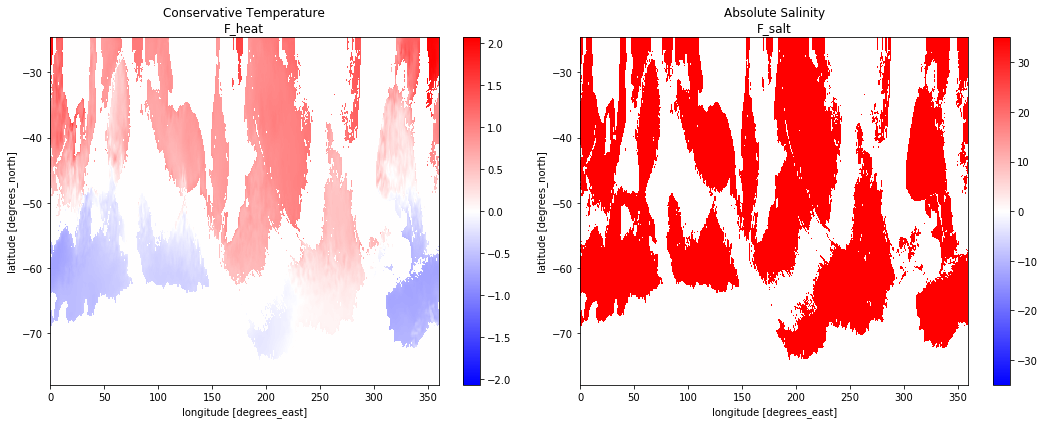

In [8]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_4[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_4[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [9]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=2km

In [10]:
alpha_4 = xr.apply_ufunc(gsw.alpha, sa_4, ct_4, 4000,
                    output_dtypes=[sst_4.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [11]:
a4 = alpha_4[0].load()

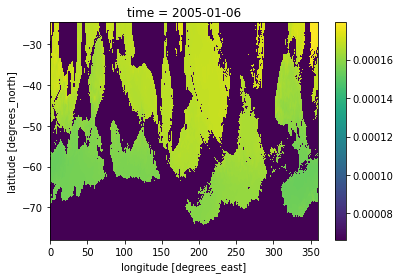

In [12]:
a4.plot()

### beta at P=2km

In [13]:
beta_4 = xr.apply_ufunc(gsw.beta, sa_4, ct_4, 4000,
                      output_dtypes=[sss_4.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [14]:
b4 = beta_4[0].load()

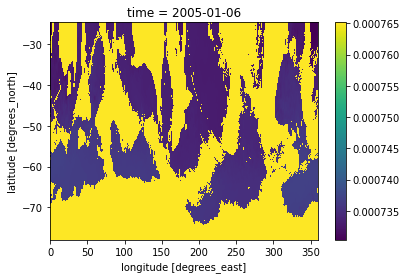

In [15]:
b4.plot()

## Temperature component of F_sigma at 2km

In [16]:
F_sig_heat_4 = (alpha_4 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_4 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

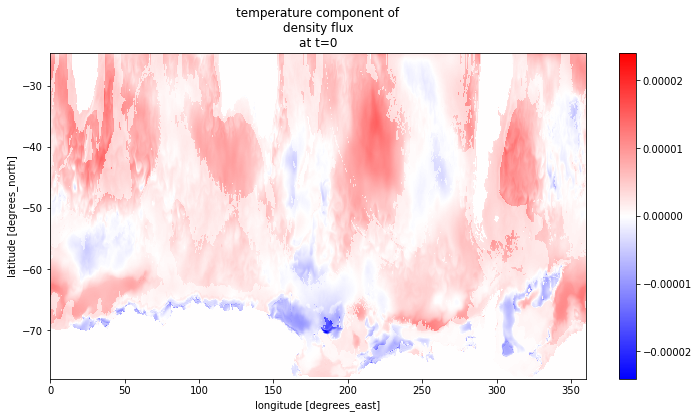

In [17]:
F_sig_heat_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [18]:
#temperature annual mean
group_time_heat_4 = F_sig_heat_4.groupby('time.month').mean(dim='time')
ann_mean_heat_4 = group_time_heat_4.mean(dim='month')
ann_mean_heat_4.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.400608e-06, 1.398369e-06, 1.395323e-06, ..., 1.380984e-06,
        1.388988e-06, 1.397515e-06],
       [1.465105e-06, 1.464021e-06, 1.462609e-06, ..., 1.439884e-06,
        1.448901e-06, 1.459810e-06],
       [1.505875e-06, 1.505596e-06, 1.504606e-06, ..., 1.478702e-06,
        1.487295e-06, 1.499233e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

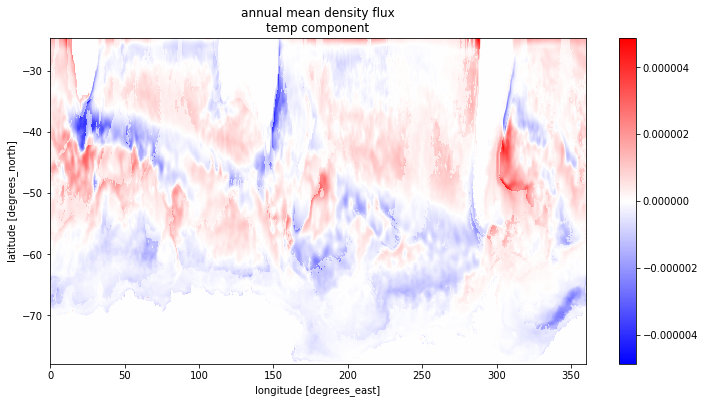

In [19]:
ann_mean_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [20]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_4 = (ann_mean_heat_4*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.013275, -0.013254, -0.013225, ..., -0.013089, -0.013165, -0.013246],
       [-0.013887, -0.013876, -0.013863, ..., -0.013648, -0.013733, -0.013836],
       [-0.014273, -0.01427 , -0.014261, ..., -0.014016, -0.014097, -0.01421 ]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

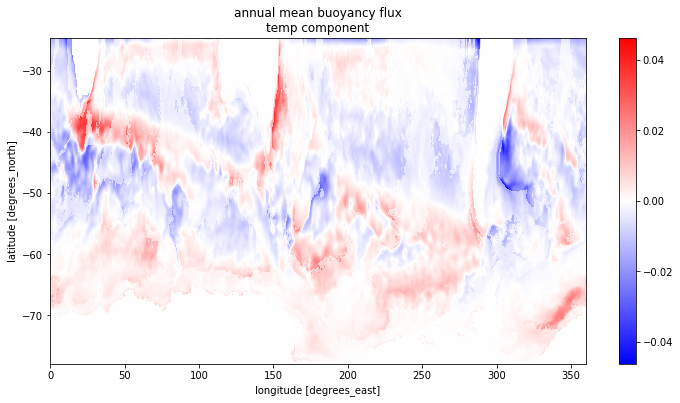

In [21]:
buoyancy_flux_heat_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [22]:
F_sig_salt_4 = beta_4 * ds_sose.SFLUX
F_sig_salt_4

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

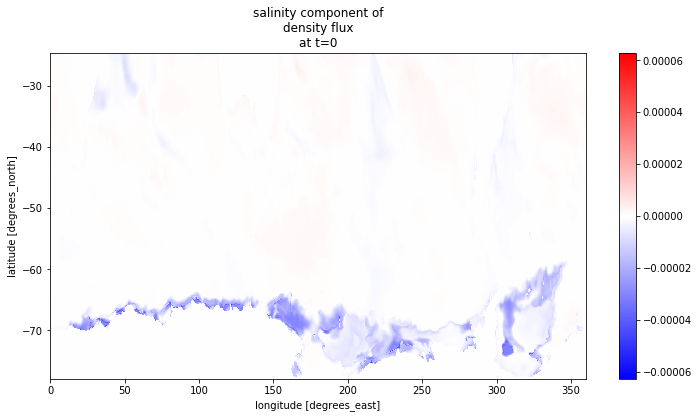

In [23]:
F_sig_salt_4[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [24]:
#temperature annual mean
group_time_salt_4 = F_sig_salt_4.groupby('time.month').mean(dim='time')
ann_mean_salt_4 = group_time_salt_4.mean(dim='month')
ann_mean_salt_4.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.032961e-06, 1.034630e-06, 1.035908e-06, ..., 1.026068e-06,
        1.027902e-06, 1.030341e-06],
       [1.030469e-06, 1.031789e-06, 1.032859e-06, ..., 1.024873e-06,
        1.026417e-06, 1.028394e-06],
       [1.031875e-06, 1.033064e-06, 1.034206e-06, ..., 1.027060e-06,
        1.028499e-06, 1.030151e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

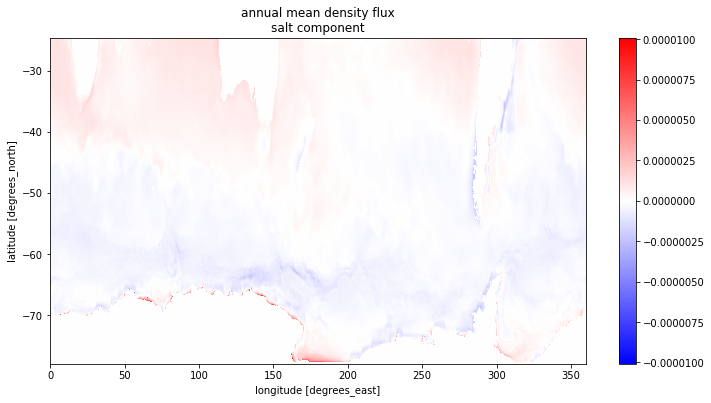

In [25]:
ann_mean_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

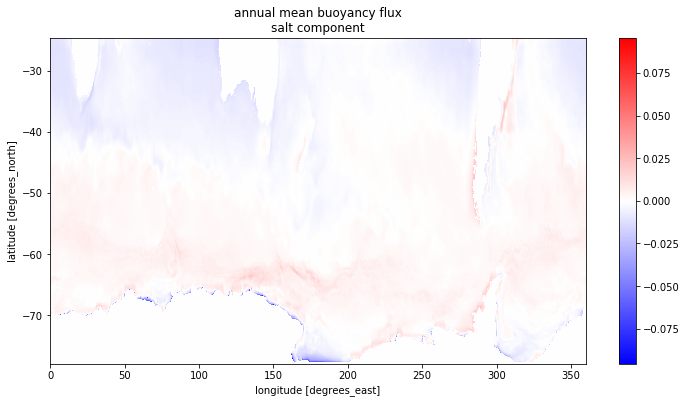

In [26]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_4 = ann_mean_salt_4*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_4.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different reference pressure levels $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [27]:
buoyancy_flux_total_4 = buoyancy_flux_heat_4 + buoyancy_flux_salt_4
buoyancy_flux_total_4

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.023066, -0.023061, -0.023044, ..., -0.022815, -0.022908, -0.023012],
       [-0.023654, -0.023656, -0.023653, ..., -0.023362, -0.023462, -0.023584],
       [-0.024053, -0.024062, -0.024064, ..., -0.02375 , -0.023845, -0.023974]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

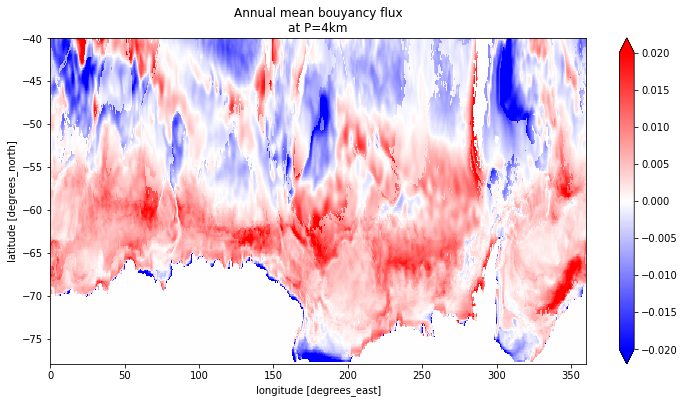

In [29]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_4.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=4km');